Welcome to the final project of Deep Learning for Robot Perception, University of Michigan. This project proposes a perception system involving object detection and depth estimation to localize cutting points for grape bunches. The idea is to come up with a vision system capable of allowing robots to perceive grapes and motion plan to grasp them. This python notebook focuses on extending the implementation proposed by *Yin et al.* in *Fruit Detection and Pose Estimation for Grape Cluster–Harvesting Robot Using Binocular Imagery Based on Deep Neural Networks* by constructing a dataset for grape stems and trains a MaskRCNN to segment the stems.

Run some imports first

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

import json

Define StemMasking masking dataset to train MaskRCNN for stem detection. The dataset was constructed in Supervisely. The mask annotations were made with the brush tool, resulting in json annotations containing bitmaps denoting the labeled masks.

In [2]:
import cv2
from PIL import Image
import os
from torch.utils.data import Dataset
import base64
import zlib
import json

class StemMaskDataset(Dataset):
  def __init__(self, img_folder, ann_folder):
    self.img_folder = img_folder
    self.ann_folder = ann_folder

    self.anns = []
    self.images = []

    for file in os.listdir(img_folder):
      img = Image.open(os.path.join(img_folder,file)).convert('RGB')
      self.images.append(img)

      json_file = file + '.json'
      with open(os.path.join(ann_folder, json_file), 'r') as f:
        json_file = json.load(f)
        self.anns.append(json_file)

    print(f'Loaded {len(self.images)} images and {len(self.anns)} anns.')

  def __len__(self):
     return len(self.images)
  
  def base64_to_mask(self, s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask
  
  def __getitem__(self, idx):
    img = self.images[idx]
    img = np.array(img)
    img = (img - img.min()) / np.max([img.max() - img.min(), 1])
    img = np.moveaxis(img, -1, 0)
    img = torch.as_tensor(img, dtype=torch.float32)  

    json_file = self.anns[idx]
    image_size = (json_file['size']['height'], json_file['size']['width'])

    listofboxes = []
    listofmasks = []
    objs = json_file['objects']
    num_objs = len(objs)
    for obj in objs:
      full_mask = torch.zeros(image_size, dtype=torch.uint8)
      encoded_data = obj['bitmap']['data']
      mask = self.base64_to_mask(encoded_data)
      mask = torch.as_tensor(mask, dtype=torch.uint8)
      ox, oy = obj['bitmap']['origin']
      full_mask[oy : oy + mask.shape[0], ox : ox + mask.shape[1]] = mask
      listofmasks.append(full_mask)

      box = [ox, oy, ox + mask.shape[1], oy + mask.shape[0]]
      box = torch.as_tensor(box, dtype=torch.float32)
      listofboxes.append(box)

    masks = torch.stack(listofmasks)
    boxes = torch.stack(listofboxes)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])

    targets = {
      "boxes": boxes,
      "labels": labels,
      "masks": masks,
      "image_id": image_id
    }
    
    return img, targets



Let's visualize a datapoint from the dataset we constructed!

Loaded 15 images and 15 anns.


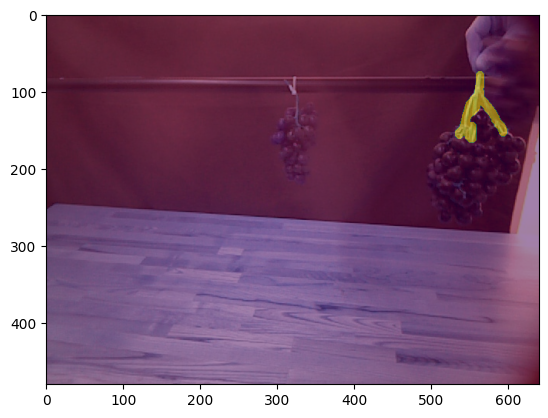

In [3]:
import matplotlib.pyplot as plt

img_folder_path = '/Users/adibalaji/Desktop/grape_juice/stem_detection/lab_grapes/grapes1_images/img'
ann_folder_path = '/Users/adibalaji/Desktop/grape_juice/stem_detection/lab_grapes/grapes1_images/ann'

dataset = StemMaskDataset(img_folder_path, ann_folder_path)

img, targets = dataset.__getitem__(1)

plt.imshow(img.permute(1,2,0).numpy())
plt.imshow(targets['masks'][1], alpha = 0.5)
plt.show()

The following cell defines some important functions used while training and testing the MaskRCNN on the stem data.

In [4]:
import os
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torch
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import faster_rcnn
from torchvision.models.detection import mask_rcnn

import matplotlib.pyplot as plt

def get_instance_segmentation_model(num_classes):
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


def train_one_epoch(model, optimizer, data_loader, tot_loss_hist):
    epoch_loss_hist = []
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader):

        #move device if in colab
        # images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Loss: {losses.item()}')
            
        epoch_loss_hist.append(losses.item())
        tot_loss_hist.append(losses.item())
    
    print(f'Average epoch loss: {sum(epoch_loss_hist)/len(epoch_loss_hist)}\n')
    epoch_loss_hist.clear()

def iou(groundtruth_mask, pred_mask):
    intersect = torch.sum(pred_mask * groundtruth_mask)
    union = torch.sum(pred_mask) + torch.sum(groundtruth_mask) - intersect
    iou = (intersect/union).item()
    return iou

def average_img_iou(preds, gts):
    ious = torch.zeros(gts.shape[0], preds.shape[0])
    for i, gt in enumerate(gts):
        for j, pr in enumerate(preds):
            current_iou = iou(gt, pr)
            ious[i, j] = current_iou

    avg_iou = ious.max(dim=1).values.mean().item()
    return avg_iou

def display_sorted_masks(image, masks):
    mask_sums = masks.view(masks.size(0), -1).sum(dim=1)
    sorted_indices = torch.argsort(mask_sums, descending=True)
    predicted_masks = masks[sorted_indices]

    num_masks = predicted_masks.shape[0] if predicted_masks.shape[0] < 6 else 6
    num_rows = (num_masks - 1) // 3 + 1
    num_cols = min(num_masks, 3)

    plt.figure(figsize=(15, 10))

    for i in range(num_masks):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image)
        plt.imshow(predicted_masks[i].permute(1, 2, 0).cpu().numpy(), alpha=0.5)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    best_mask = predicted_masks[0]
    return best_mask

def sort_masks_by_sum(masks):
    mask_sums = masks.view(masks.size(0), -1).sum(dim=1)
    sorted_indices = torch.argsort(mask_sums, descending=True)
    predicted_masks = masks[sorted_indices]
    return predicted_masks

This cell sets up the PyTorch dataloader and MaskRCNN model for training. You may adjust the batch_size as needed.

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))  
batch_size = 2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)
print(f'Dataset of size {dataset.__len__()} loaded')

num_classes = 2  #grape and background
model = get_instance_segmentation_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

Dataset of size 15 loaded


Train the model for 'num_epochs', adjusting the learning rate 'lr' as needed. Model shows acceptable results at a loss of ~30.

Loss: 142.21038818359375
Loss: 80.13349914550781
Loss: 82.37513732910156
Loss: 84.94503784179688
Loss: 84.01363372802734
Loss: 74.54499053955078
Loss: 97.09503936767578
Average epoch loss: 92.18824659075055

Loss: 88.40211486816406
Loss: 82.46822357177734
Loss: 92.5680160522461
Loss: 79.62727355957031
Loss: 81.59598541259766
Loss: 61.735511779785156
Loss: 96.26679229736328
Average epoch loss: 83.23770250592914

Trained 2 epochs..


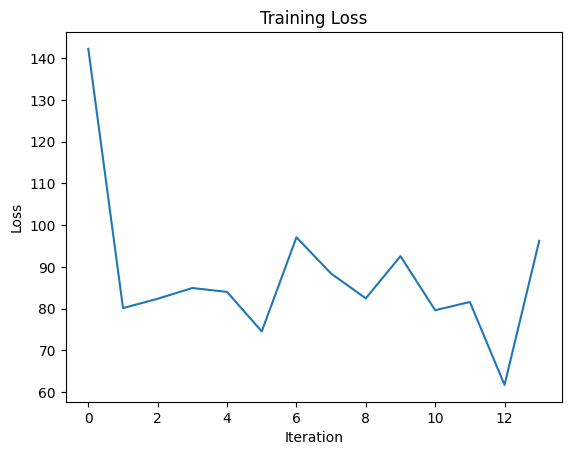

In [6]:
optimizer = torch.optim.Adam(params, lr=5e-7)

loss_history = []
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, loss_history)

print(f'Trained {num_epochs} epochs..')

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Save the model state dictionary

In [69]:
torch.save(model.state_dict(), 'stem_mask1.5.pth')

Load model for inference

In [9]:
grape_model = get_instance_segmentation_model(num_classes)
grape_model.load_state_dict(torch.load('stem_mask1.4.pth'))
grape_model.eval()

print('model set to eval!')

model set to eval!


Visualize an example result of the model. Looks pretty cool!

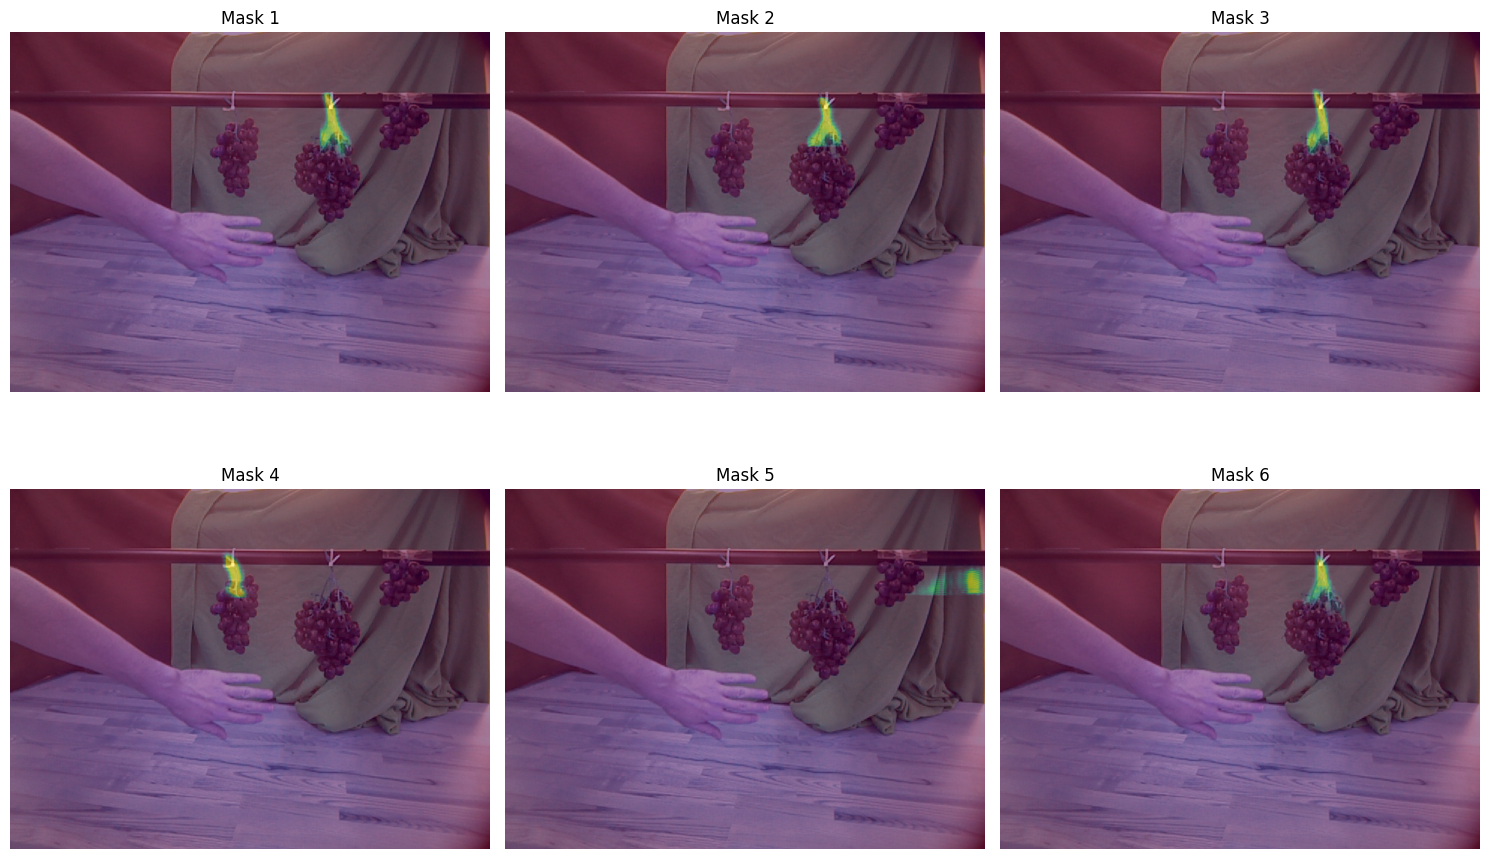

bbox shape: torch.Size([37, 4])
masks shape: torch.Size([37, 1, 480, 640])


In [13]:
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image
import matplotlib.pyplot as plt

test = Image.open('/Users/adibalaji/Desktop/grape_juice/stem_detection/test_stems.jpg')
test_tensor = to_tensor(test).unsqueeze(0)

with torch.no_grad():
    prediction = grape_model(test_tensor)
    prediction = prediction.pop()

predicted_boxes = prediction['boxes']
predicted_masks = prediction['masks']

best_mask = display_sorted_masks(test, predicted_masks)

print(f'bbox shape: {predicted_boxes.shape}')
print(f'masks shape: {predicted_masks.shape}')

We can use the 3D reconstruction pipeline described in grape_masking/wgisd_masking to estimate the pose of the stem for harvesting.